## Курсовой проект. Библиотеки Python для Data Science: продолжение. Прогнозирование с помощью модели классификации.

### Задача:

На основании имеющихся данных о клиентах банка построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

### Наименование файлов с данными:

course_project_train.csv - обучающий датасет

course_project_test.csv - тестовый датасет

### Целевая переменная:

Credit Default - факт невыполнения крудитных обязательств

### Метрика качества:

F1-score

### Требования к решению:

* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

## Построение модели классификации

### Загрузка библиотек

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve

# Алгоритмы классификации 

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Метрика F1:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# статистика
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import probplot

### Обзор обучающего датасета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [3]:
df = pd.read_csv(r'.\course_project_train.csv')
df_test = pd.read_csv(r'.\course_project_test.csv')

In [4]:
df['ID'] = df.index.tolist()

In [5]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4


In [6]:
df.shape

(7500, 18)

In [7]:
df.info()   # есть пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.00,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.00,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.00,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.50,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.50,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.00,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.00,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.00,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.00,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.50,209323.0,360406.25,6.506797e+06


In [9]:
len(df) - df.count() # количество пропусков по признакам на обучающей выборке

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
dtype: int64

In [10]:
len(df_test) - df_test.count()   # количество пропусков по признакам на тестовой выборке

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

### Обработка выбросов. Обработка пропусков. Анализ данных.

#### Обработка Home Ownership

In [11]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

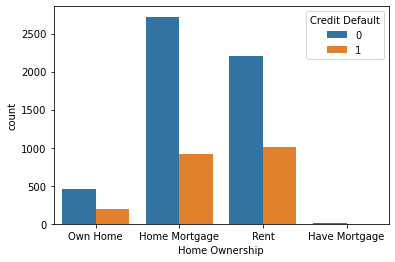

In [12]:
sns.countplot(x="Home Ownership", hue='Credit Default', data=df)
plt.show()

In [13]:
df = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='Home Ownership')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')], axis=1)
# добавление столбцов Home Ownership_

#### Обработка Annual Income

In [14]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [15]:
def qq_plot(target_name):
    plt.figure(figsize=(20,8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    df[target_name].hist()
    plt.subplot(122)
    probplot(df[target_name],dist='norm',plot=plt)
   
    
    plt.show()

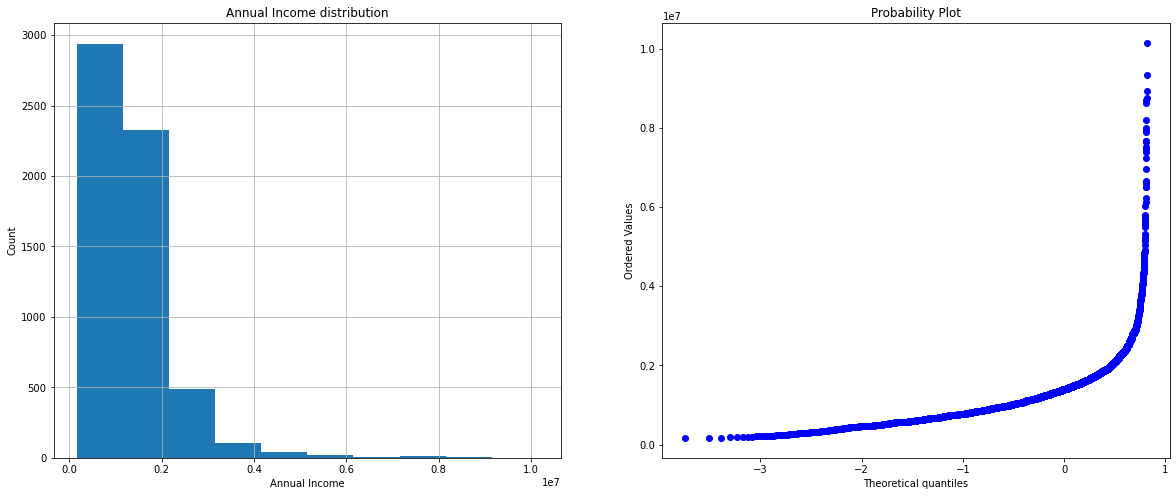

In [16]:
qq_plot('Annual Income')

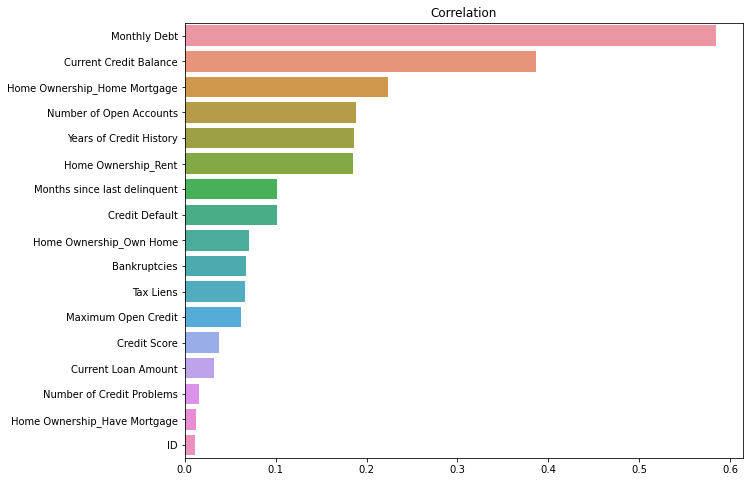

In [17]:
# корреляция признаков с Annual Income
FEATURE_NAMES = df.columns.drop('Annual Income').tolist()
corr_Annual_Income = df[FEATURE_NAMES + ['Annual Income']].corr().iloc[:-1, -1]
corr_Annual_Income = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation')
plt.show()

In [18]:
#  выбираем 7 наиболее коррелирующих признаков 
TARGET_FEATURE = list(corr_Annual_Income.index[0:6])

In [19]:
#  набор данных для обучения
data = df.loc[(df['Annual Income'].notnull()), TARGET_FEATURE + ['Annual Income']]
data

,Monthly Debt,Current Credit Balance,Home Ownership_Home Mortgage,Number of Open Accounts,Years of Credit History,Home Ownership_Rent,Annual Income
0,7914.0,47386.0,0,11.0,26.3,0,482087.0
1,18373.0,394972.0,0,15.0,15.3,0,1025487.0
2,13651.0,308389.0,1,11.0,35.0,0,751412.0
3,11338.0,95855.0,0,8.0,22.5,0,805068.0
4,7180.0,93309.0,0,13.0,13.6,1,776264.0
...,...,...,...,...,...,...,...
7491,61150.0,108889.0,1,18.0,21.3,0,2833185.0
7493,27562.0,167428.0,0,14.0,16.5,1,1257610.0
7495,1900.0,73492.0,0,3.0,8.5,1,402192.0
7496,12783.0,456399.0,1,10.0,26.5,0,1533984.0


In [20]:
%%time

# обучение на Регрессии

model_Annual_Income = LogisticRegression()
model_Annual_Income.fit(data[TARGET_FEATURE], data['Annual Income'])

Wall time: 4min 42s


LogisticRegression()

In [21]:
# заполним пропуски

df.loc[(df['Annual Income'].isnull()), ['Annual Income']] = model_Annual_Income.predict(df.loc[(df['Annual Income'].isnull()), TARGET_FEATURE])

df_test.loc[(df_test['Annual Income'].isnull()), ['Annual Income']] = model_Annual_Income.predict(df_test.loc[(df_test['Annual Income'].isnull()), TARGET_FEATURE])

In [22]:
# Тест Шапиро-Вилка

shapiro(df['Annual Income']) 

ShapiroResult(statistic=0.7502482533454895, pvalue=0.0)

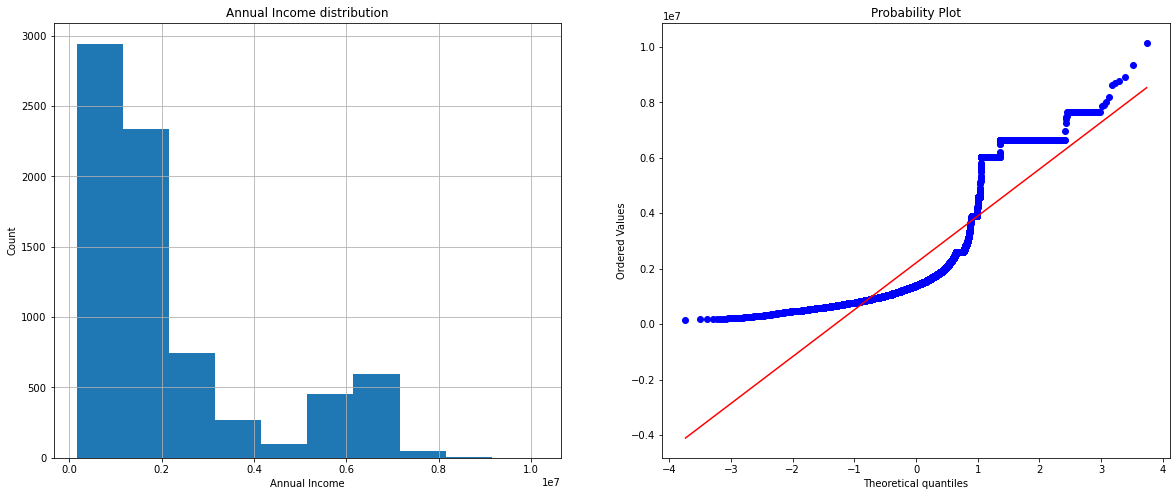

In [23]:
qq_plot('Annual Income')

In [24]:
Annual_Income_with_target_s = df[['Annual Income', 'Credit Default']]
Annual_Income_target_0 = df.loc[df['Credit Default'] == 0, ['Annual Income']]
Annual_Income_target_1 = df.loc[df['Credit Default'] == 1, ['Annual Income']]

In [25]:
#  U-критерий Манна — Уитни - Статистический критерий, 
# используемый для оценки различий между двумя независимыми выборками по уровню какого-либо признака, измеренного количественно.
mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)

MannwhitneyuResult(statistic=array([5893699.]), pvalue=array([0.01641382]))

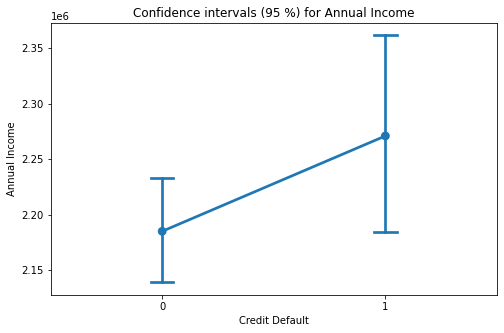

In [26]:
plt.figure(figsize=(8,5))

sns.pointplot(x='Credit Default', y='Annual Income', data=Annual_Income_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual Income')

plt.show()

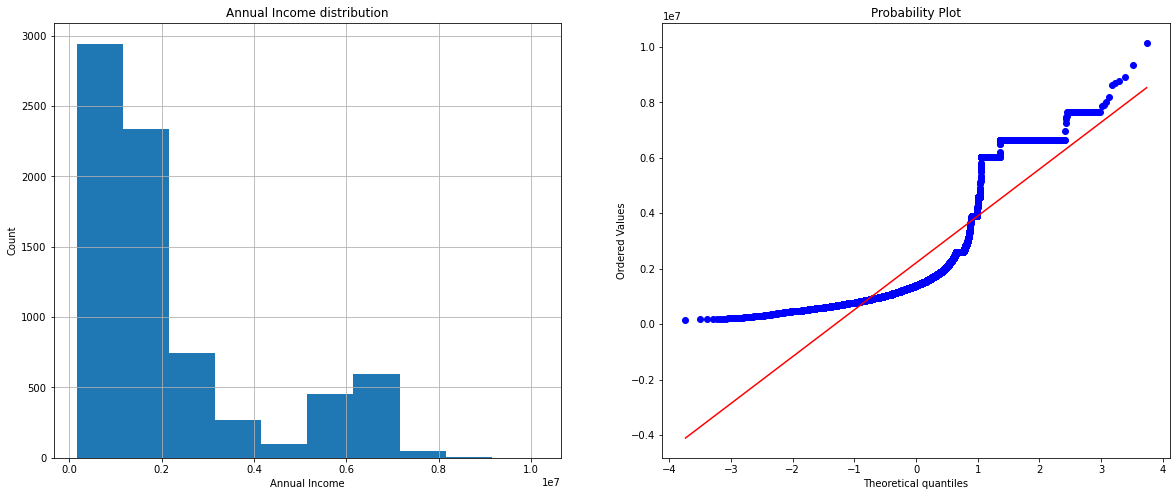

In [27]:
qq_plot('Annual Income')

In [28]:
df.loc[df['Annual Income'] > df['Annual Income'].quantile(.99), ['Annual Income']] = df['Annual Income'].quantile(.99)

df_test.loc[df_test['Annual Income'] > df_test['Annual Income'].quantile(.99), ['Annual Income']] = df_test['Annual Income'].quantile(.99)

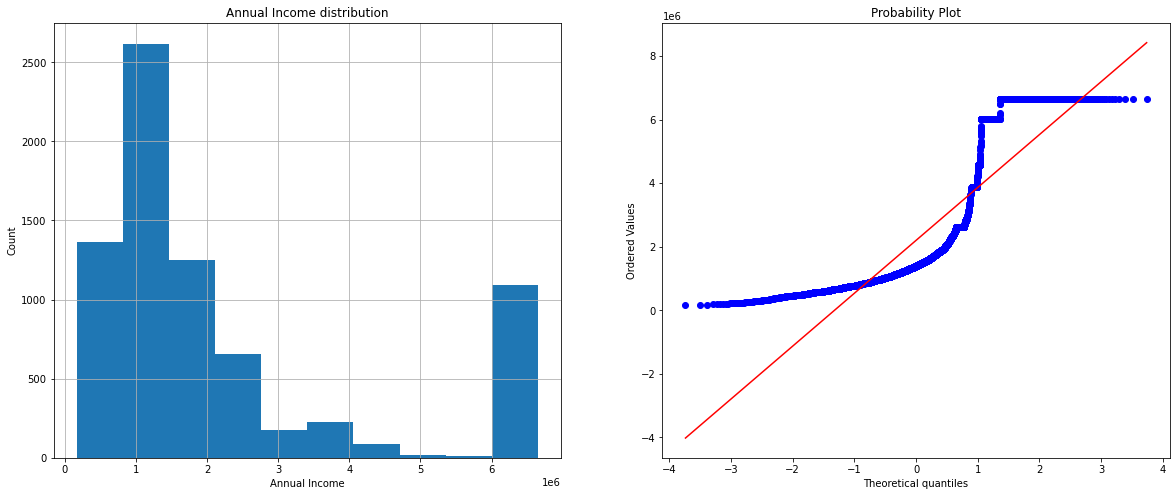

In [29]:
qq_plot('Annual Income')

#### Обработка Years in current job

In [30]:
#  количество лет на текущем месте работы
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

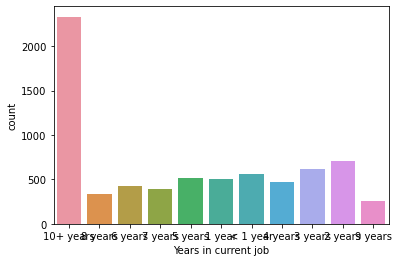

In [31]:
sns.countplot(x="Years in current job", data=df)
rcParams['figure.figsize'] = 20,8.27
plt.show()

<AxesSubplot:xlabel='Years in current job', ylabel='count'>

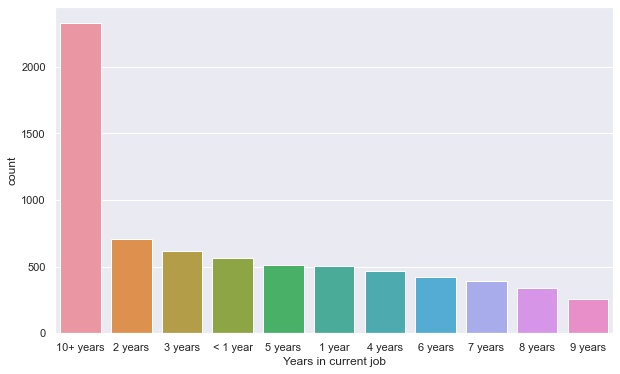

In [32]:
#  распределение от стажа 
sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
sns.countplot(df['Years in current job'], order = df['Years in current job'].value_counts().index) 

In [33]:
df['Years in current job'] = df['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df.loc[df['Years in current job'].isnull(), 'Years in current job'] = 11



df_test['Years in current job'] = df_test['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 11

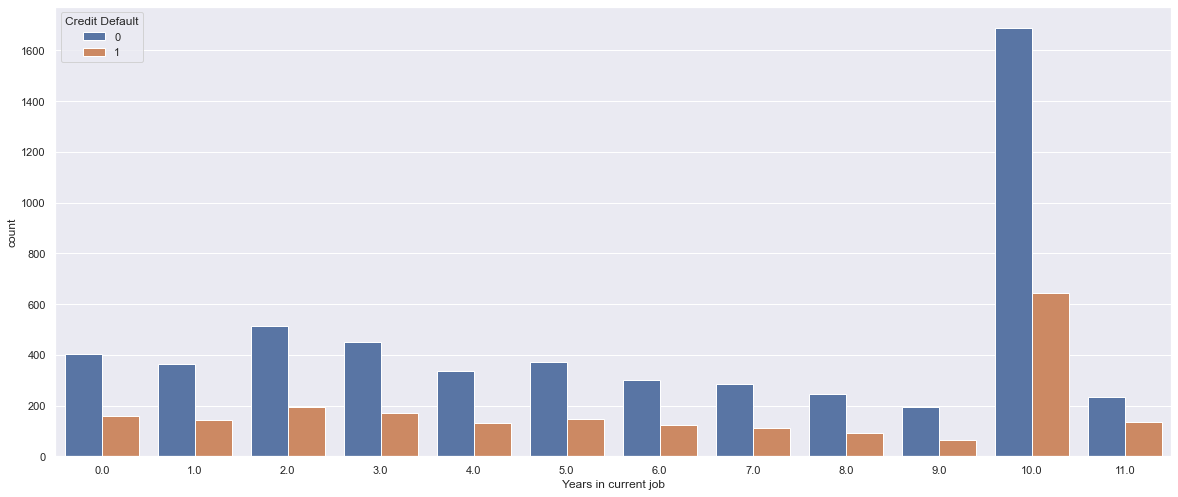

In [34]:
sns.countplot(x="Years in current job", hue='Credit Default', data=df)
plt.legend(loc="upper left", title='Credit Default')
plt.show()

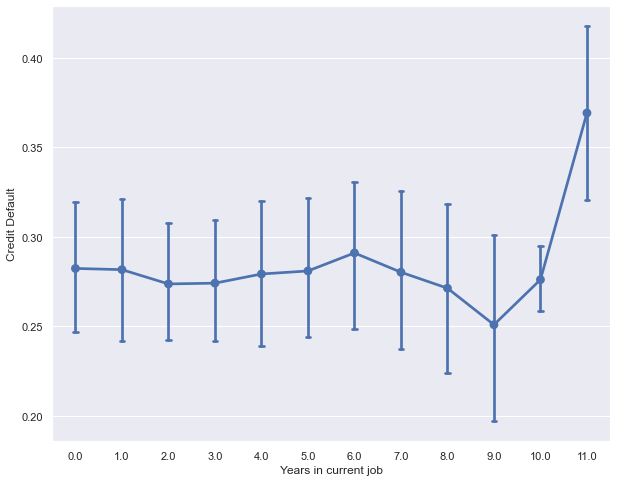

In [35]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Years in current job', y='Credit Default', data=df, capsize=.1,);

#### Обработка Tax Liens

In [36]:
#  налоговые обременения
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

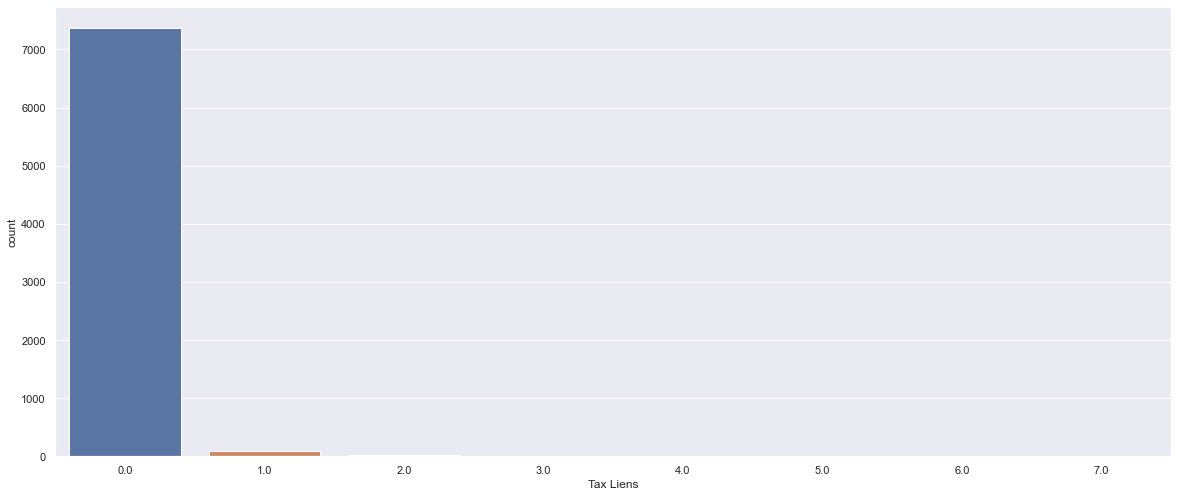

In [37]:
sns.countplot(x="Tax Liens", data=df)
plt.show()

#### Обработка Number of Open Accounts

In [38]:
#  количество открытых счетов
df['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

In [39]:
df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
41.0      1
38.0      1
35.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

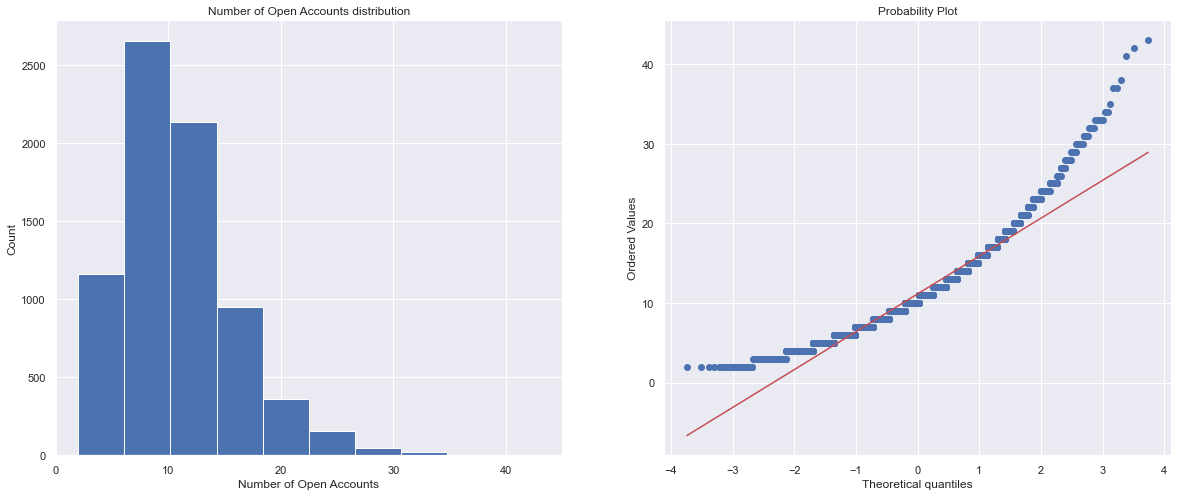

In [40]:
qq_plot('Number of Open Accounts')

In [41]:
df.loc[(df['Number of Open Accounts'] > df['Number of Open Accounts'].quantile(.90)), :].shape

(731, 22)

In [42]:
df.loc[df['Number of Open Accounts'] > df['Number of Open Accounts'].quantile(.90), ['Number of Open Accounts']] =\
            df['Number of Open Accounts'].median()

df_test.loc[df_test['Number of Open Accounts'] > df_test['Number of Open Accounts'].quantile(.90),  \
            ['Number of Open Accounts']] = df_test['Number of Open Accounts'].median()

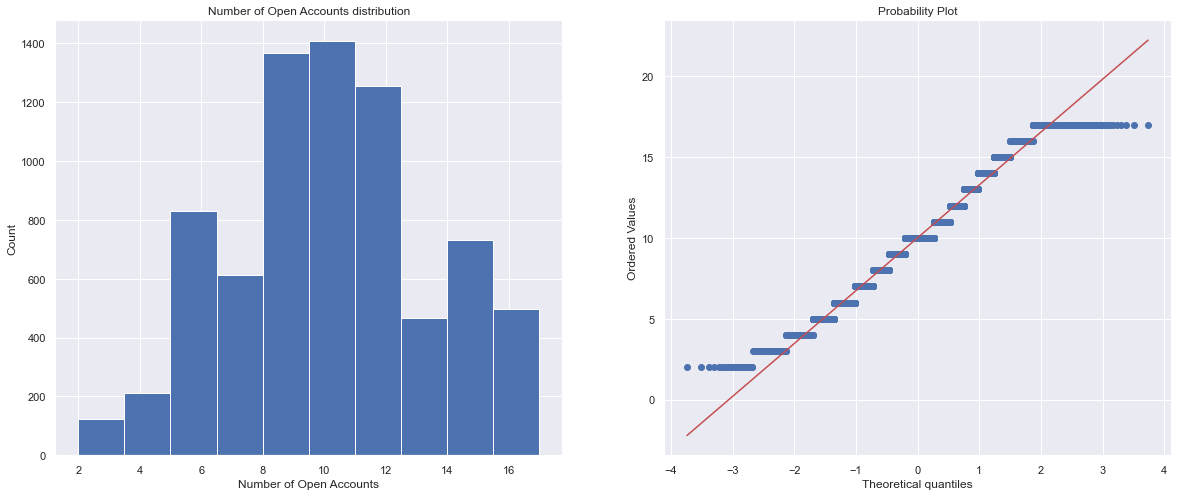

In [43]:
qq_plot('Number of Open Accounts')

#### Обработка Years of Credit History

In [44]:
#  количество лет кредитной истории
df['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
44.0      1
39.8      1
40.0      1
39.9      1
48.3      1
Name: Years of Credit History, Length: 408, dtype: int64

<AxesSubplot:>

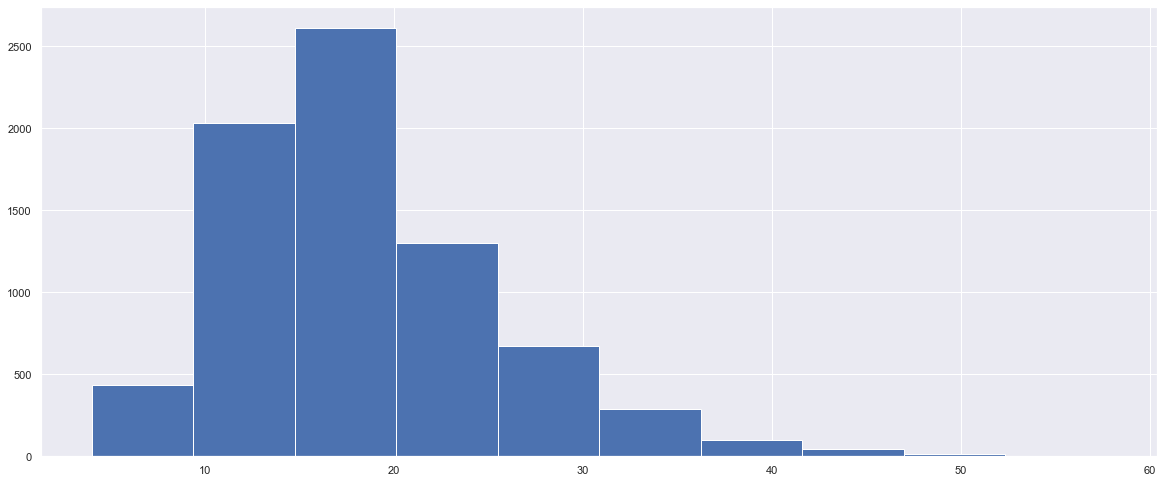

In [45]:
df['Years of Credit History'].hist()

In [46]:
# все, что больше 30 - заменяем на 30

df.loc[df['Years of Credit History'] > 30, ['Years of Credit History']] = 30

df_test.loc[df_test['Years of Credit History'] > 40, ['Years of Credit History']] = 30

<AxesSubplot:>

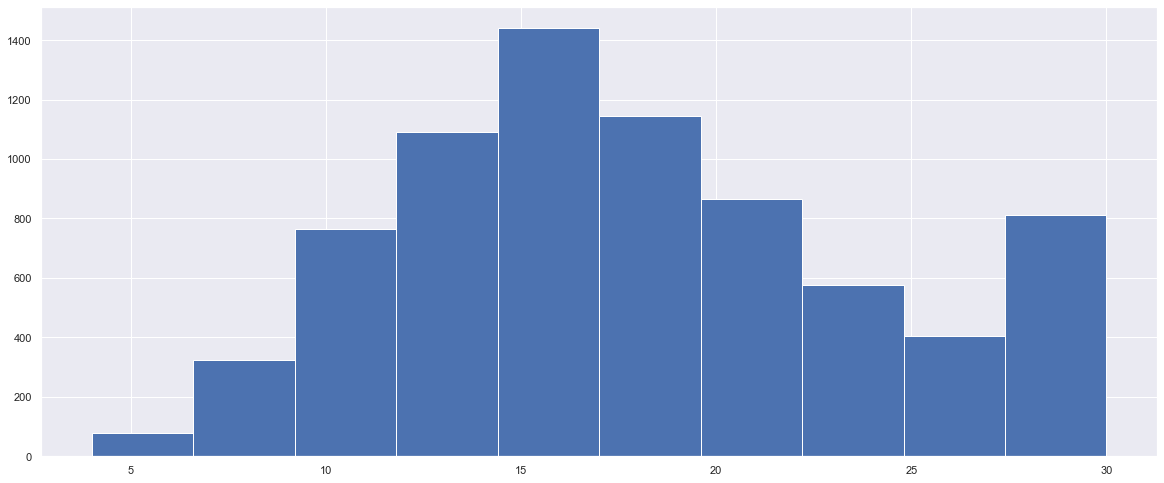

In [47]:
df['Years of Credit History'].hist()

#### Обработка Maximum Open Credit

In [48]:
#  Максимальный открытый кредит
df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

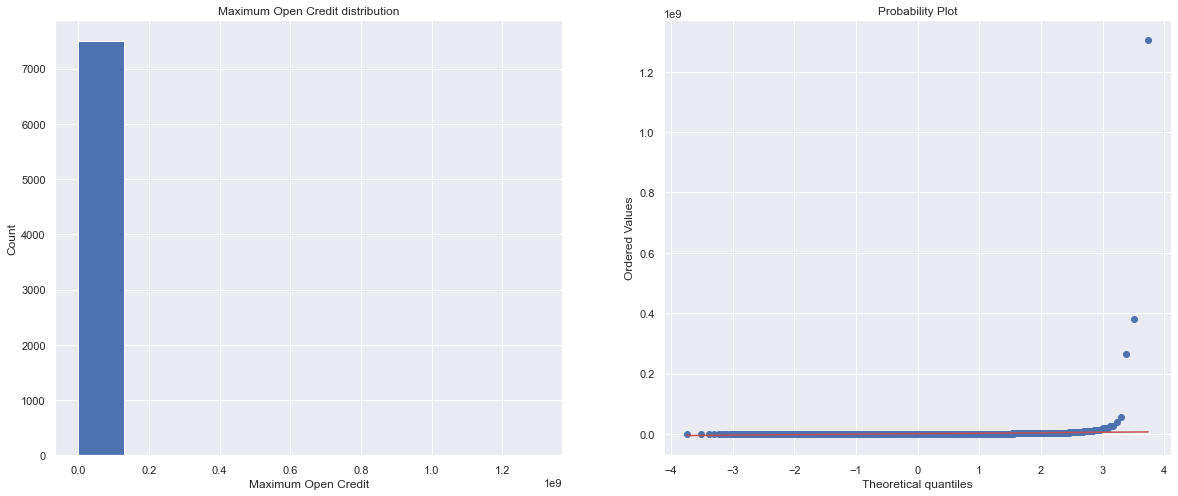

In [49]:
qq_plot('Maximum Open Credit')

In [50]:
df.loc[df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.90), ['Maximum Open Credit']] =\
            df['Maximum Open Credit'].quantile(.95)

df_test.loc[df_test['Maximum Open Credit'] > df_test['Maximum Open Credit'].quantile(.90), ['Maximum Open Credit']] =\
            df_test['Maximum Open Credit'].quantile(.90)

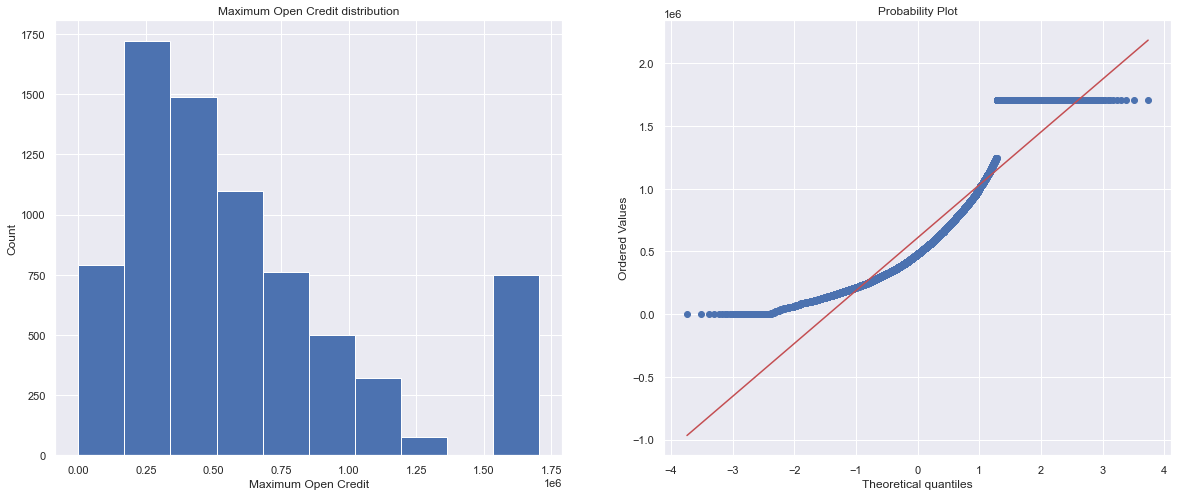

In [51]:
qq_plot('Maximum Open Credit')

#### Обработка Number of Credit Problems

In [52]:
# проблемы с кредитом
df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

#### Обработка Bankruptcies

In [53]:
#  банкротства
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [54]:
df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

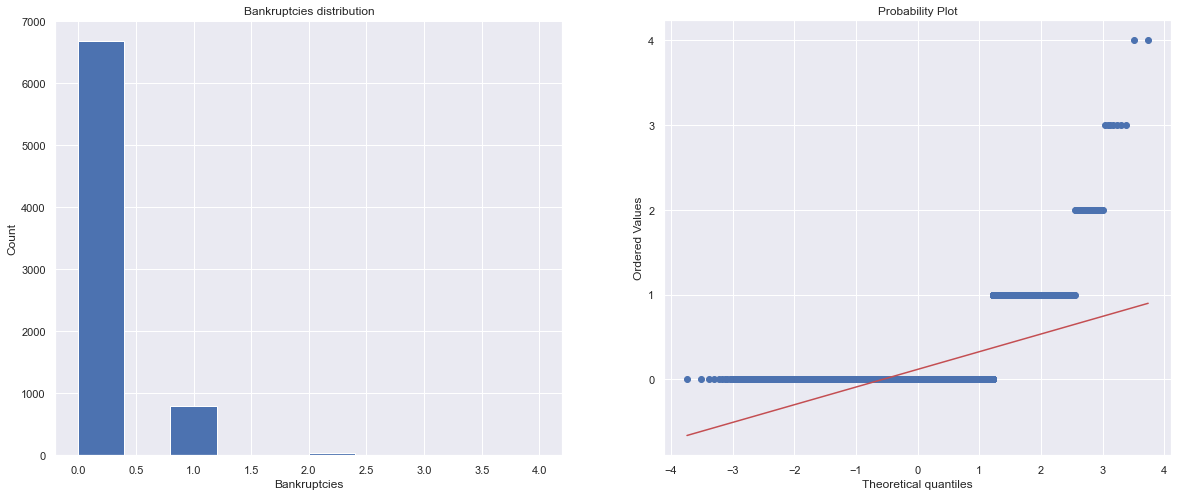

In [55]:
qq_plot('Bankruptcies')

#### Обработка Months since last delinquent

In [56]:
#  количество месяцев с последней просрочки кредита
df['Months since last delinquent'].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
12.0     65
         ..
86.0      1
118.0     1
84.0      1
91.0      1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

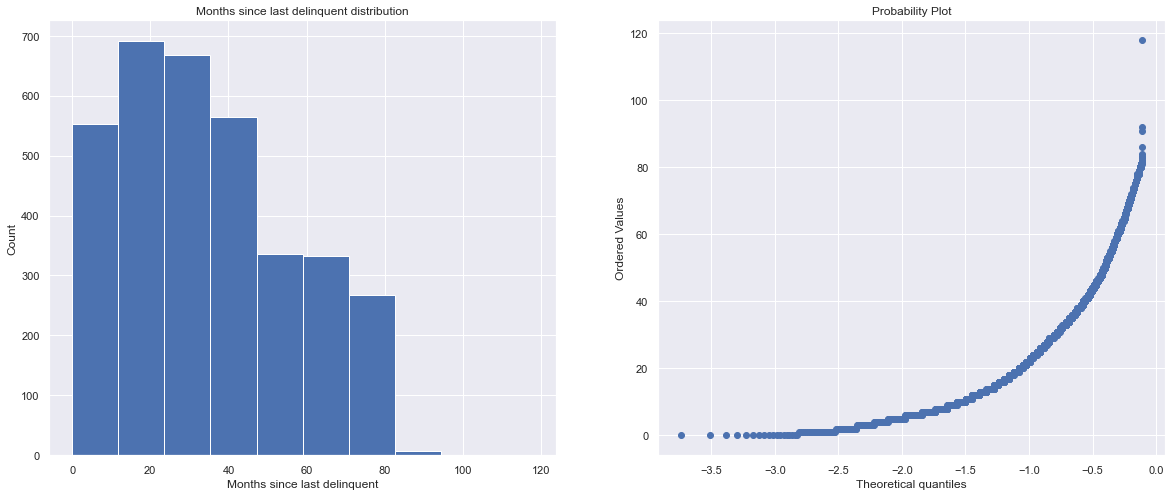

In [57]:
qq_plot('Months since last delinquent')

In [58]:
df['Months since last delinquent NULL'] = df['Months since last delinquent'].isnull()
df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0


df_test['Months since last delinquent NULL'] = df_test['Months since last delinquent'].isnull()
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

#### Обработка Purpose

In [59]:
#  цель кредита
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [60]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

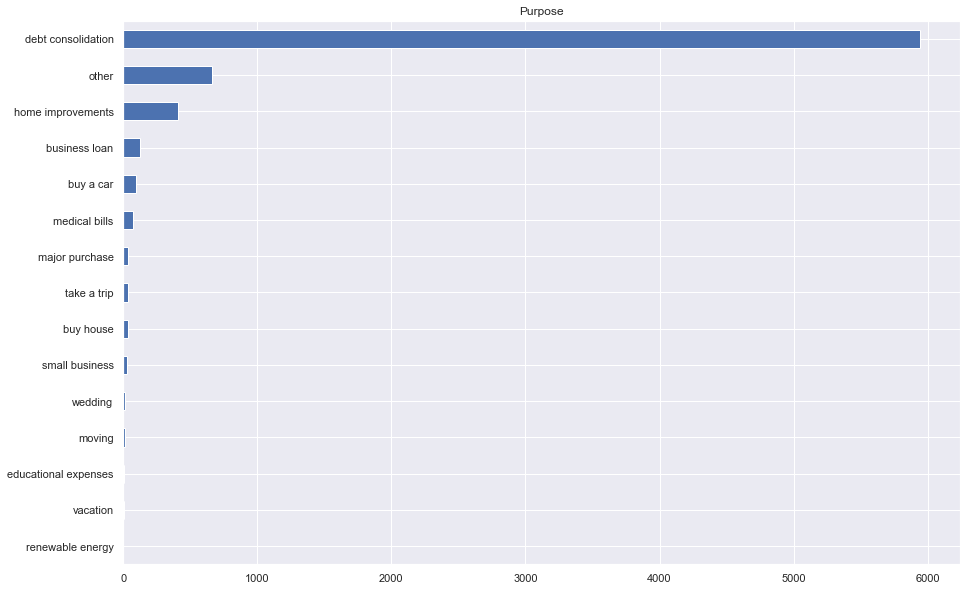

In [61]:
df['Purpose'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Purpose', figsize=(15,10));

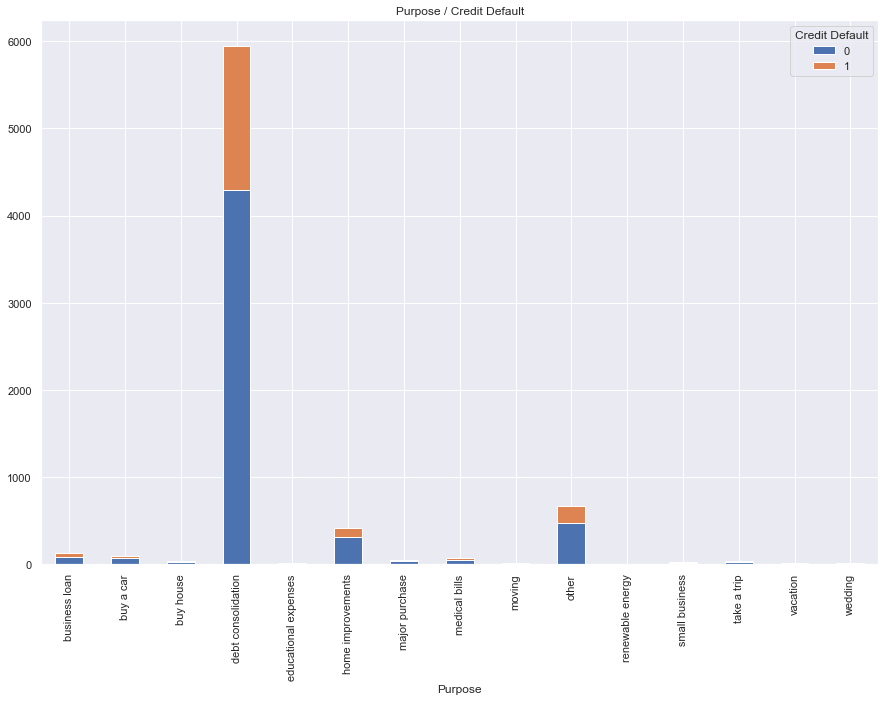

In [62]:
purpose_deafult = df[['Purpose','Credit Default']]
pd.crosstab(purpose_deafult['Purpose'], purpose_deafult['Credit Default']).plot \
(kind='bar', stacked=True, figsize=(15,10), title="Purpose / Credit Default");

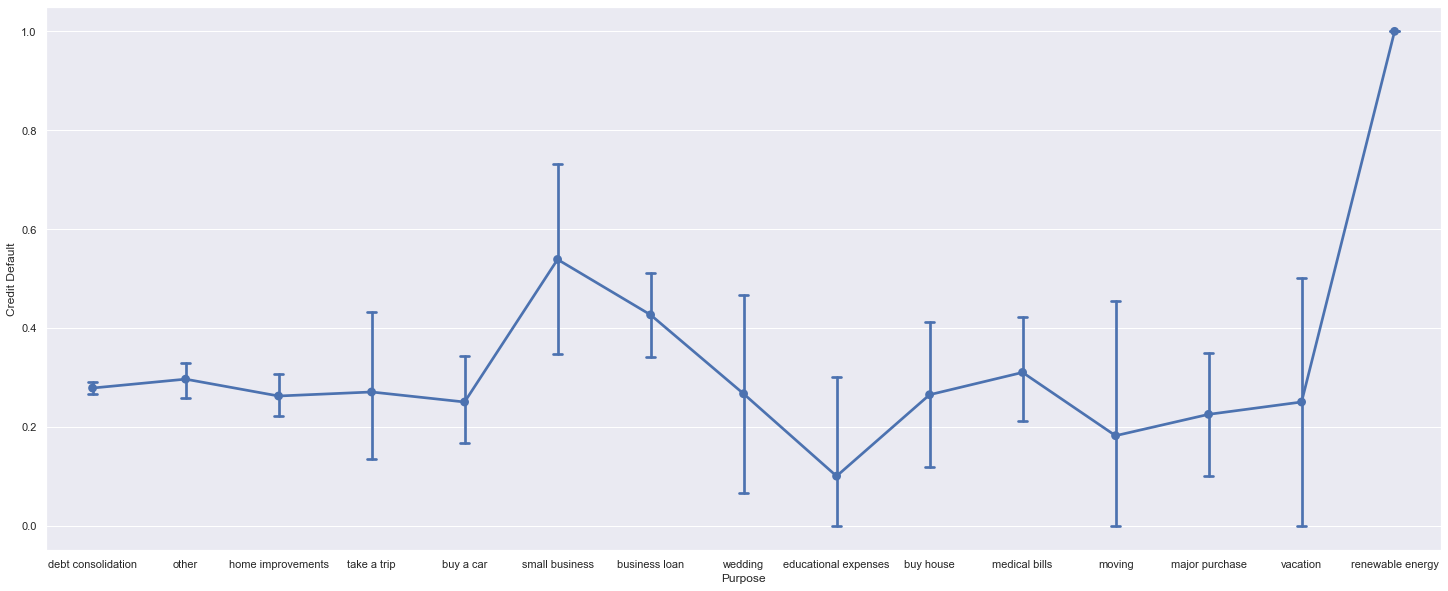

In [63]:
plt.figure(figsize=(25, 10))
sns.pointplot(x='Purpose', y='Credit Default', data=df, capsize=.1,);

In [64]:
#  разбиение на 4 категории

df['Purpose'] = df['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

In [65]:
df_test['Purpose'] = df_test['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

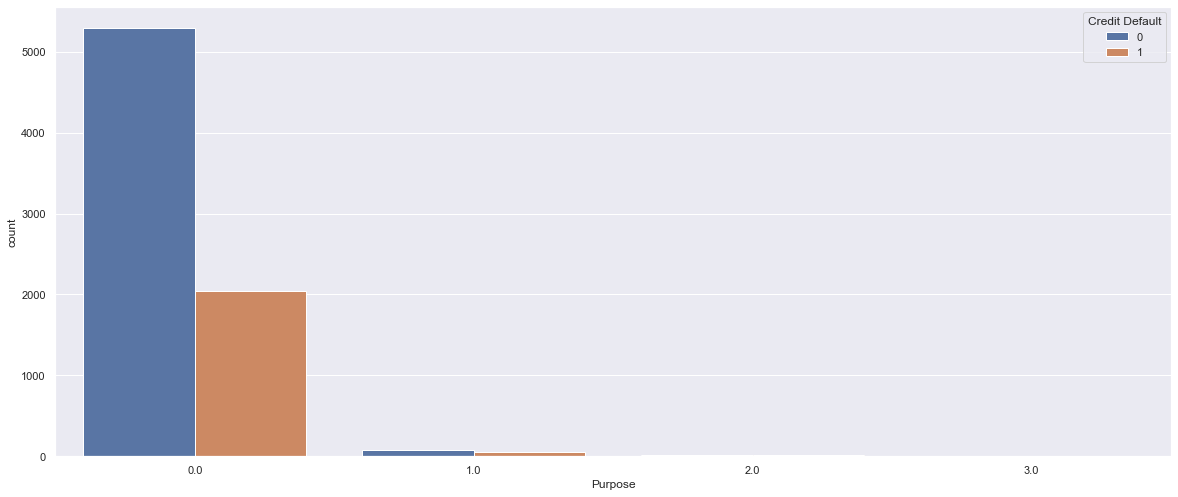

In [66]:
sns.countplot(x="Purpose", hue='Credit Default', data=df)
plt.show()

#### Обработка Term

In [67]:
#  срок кредита
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [68]:
df['Term'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)
df_test['Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)

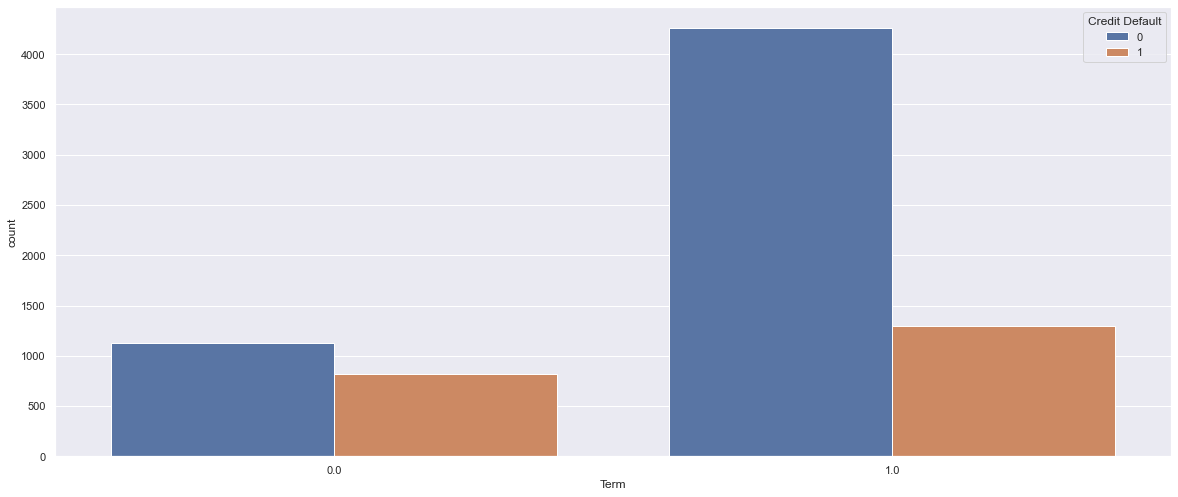

In [69]:
sns.countplot(x="Term", hue='Credit Default', data=df)
plt.show()

#### Обработка Current Loan Amount

In [70]:
#  текущая сумма кредита
df['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
222926.0        5
265826.0        5
             ... 
351626.0        1
212498.0        1
187682.0        1
108922.0        1
26928.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [71]:
df['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

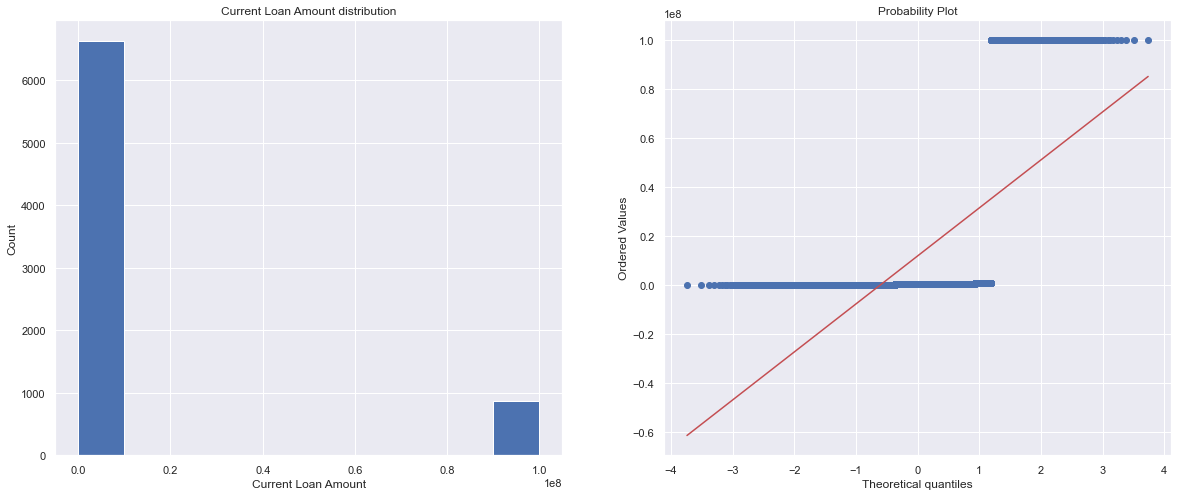

In [72]:
qq_plot('Current Loan Amount')

In [73]:
# вынос больших выбросов в отдельную переменную

df['Current Loan Amount BIG'] = df['Current Loan Amount'] == 99999999
df_test['Current Loan Amount BIG'] = df_test['Current Loan Amount'] == 99999999

In [74]:
df.loc[df['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None
df_test.loc[df_test['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None

In [75]:
# замена на среднее
df.loc[df['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df['Current Loan Amount'].mean() 
df_test.loc[df_test['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df_test['Current Loan Amount'].mean()

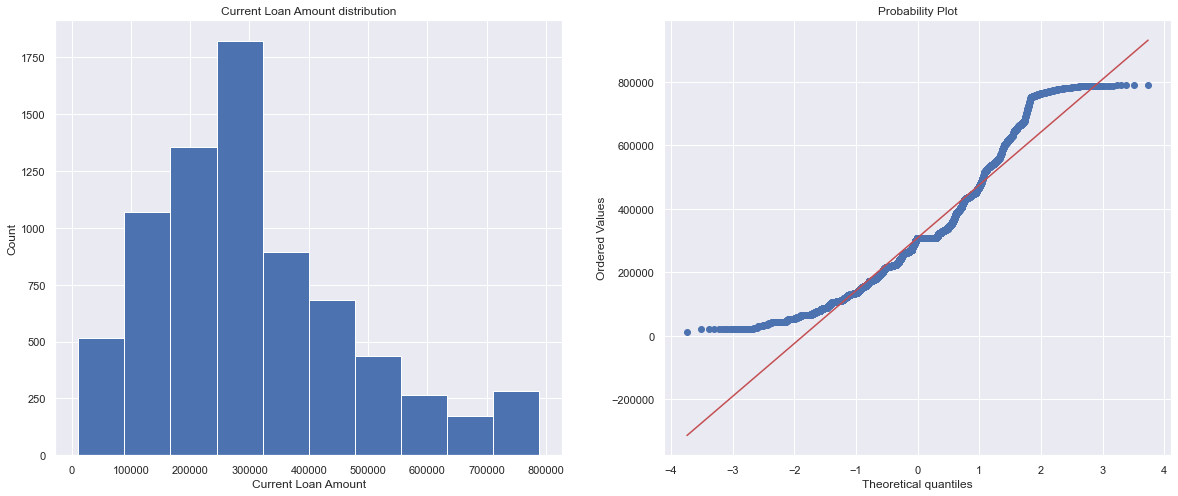

In [76]:
qq_plot('Current Loan Amount')

#### Обработка Current Credit Balance

In [77]:
#  текущий кредитный балан
df['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

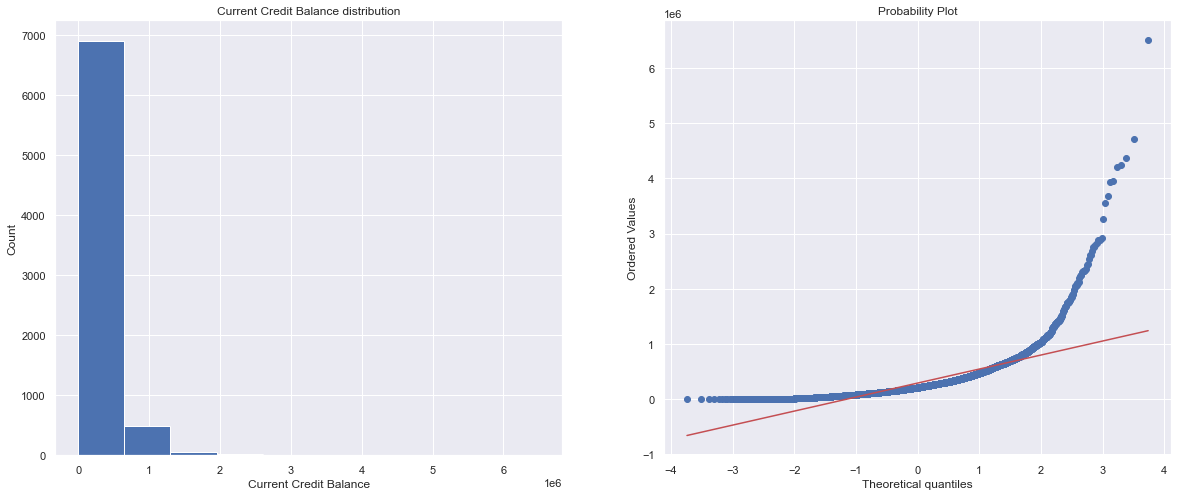

In [78]:
qq_plot('Current Credit Balance')

In [79]:
# выбросы
df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.90), :].shape

(750, 24)

In [80]:
df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.90), \
       ['Current Credit Balance']] = df['Current Credit Balance'].quantile(.90) 

df_test.loc[df_test['Current Credit Balance'] > df_test['Current Credit Balance'].quantile(.90), \
       ['Current Credit Balance']] = df_test['Current Credit Balance'].quantile(.90) 

#### Обработка Monthly Debt

In [81]:
#  ежемесячный долг
df['Monthly Debt'].value_counts()

0.0        6
19222.0    4
19667.0    4
12986.0    3
13356.0    3
          ..
33217.0    1
8203.0     1
15150.0    1
1992.0     1
9061.0     1
Name: Monthly Debt, Length: 6716, dtype: int64

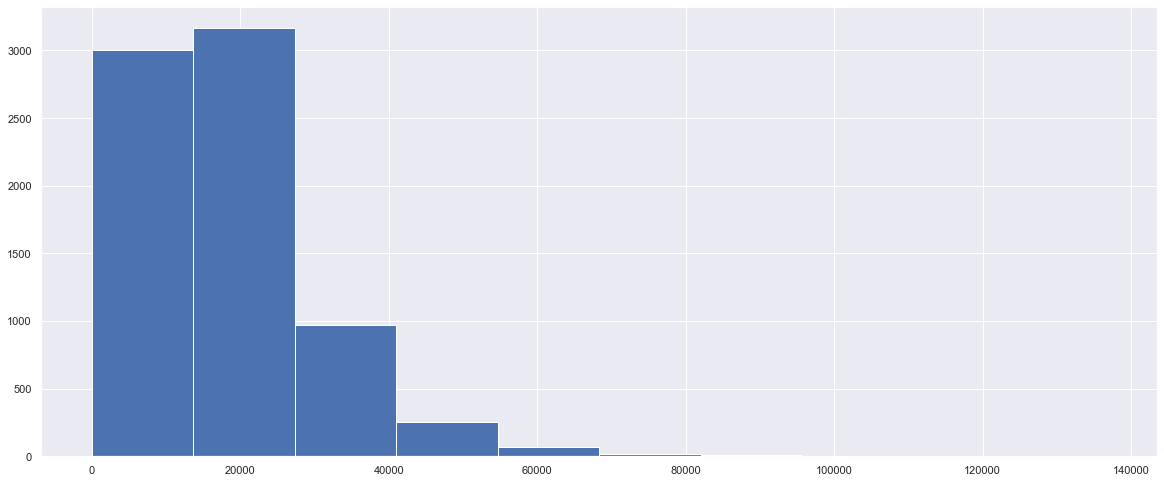

In [82]:
df['Monthly Debt'].hist();

In [83]:
df.loc[df['Monthly Debt'] > df['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df['Monthly Debt'].mean()

df_test.loc[df_test['Monthly Debt'] > df_test['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df_test['Monthly Debt'].mean()

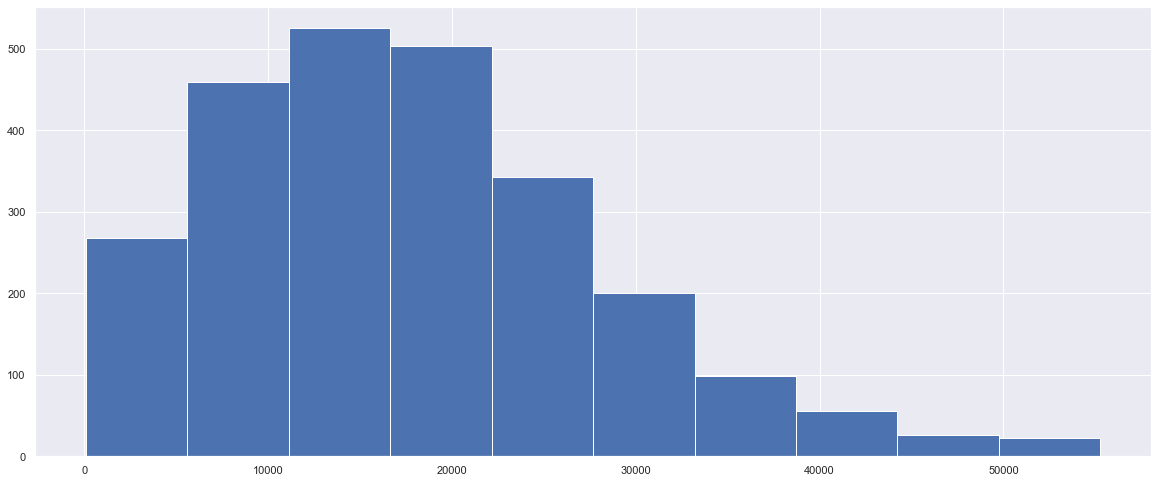

In [84]:
df_test['Monthly Debt'].hist();

#### Обработка Credit Score

In [85]:
#  кредитный рейтинг
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

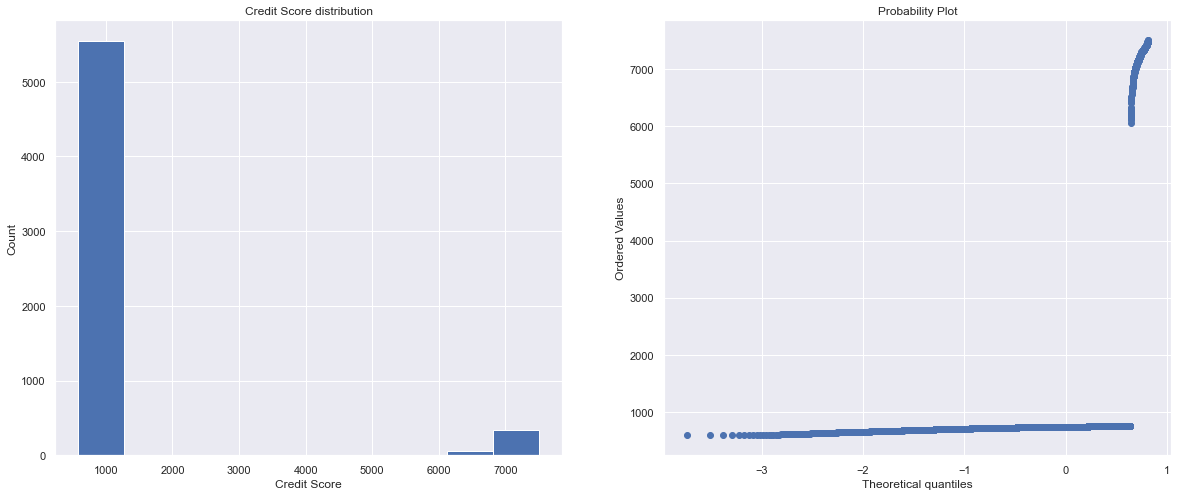

In [86]:
qq_plot('Credit Score')

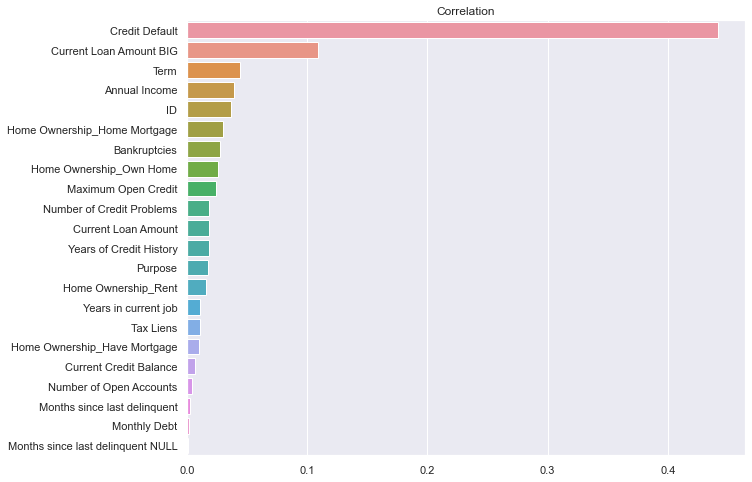

In [87]:
FEATURE_NAMES = df.columns.drop('Credit Score').tolist()
corr_Credit_Score = df[FEATURE_NAMES + ['Credit Score']].corr().iloc[:-1, -1]
corr_Credit_Score = np.abs(corr_Credit_Score).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Credit_Score.values, y=corr_Credit_Score.index)

plt.title('Correlation')
plt.show()

### Отбор признаков

In [88]:
#  для обучения выбираем наиболее важные признаки
TARGET_FEATURE = [           
                 'Current Loan Amount BIG',
                 'Current Loan Amount',
                 'Term',
                 'Annual Income',                 
                 'Home Ownership_Home Mortgage',
                 'Bankruptcies',
                 'Home Ownership_Own Home',
                 'Maximum Open Credit',
                 'Number of Credit Problems',
                 'Purpose',
                 'Home Ownership_Rent',
                 'Years of Credit History',
                 'Years in current job'
                 ]

In [89]:
# отбираем набор данных для обучения
data = df.loc[(df['Credit Score'].notnull()), TARGET_FEATURE + ['Credit Score']]

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Current Loan Amount BIG       5943 non-null   bool   
 1   Current Loan Amount           5943 non-null   float64
 2   Term                          5943 non-null   float64
 3   Annual Income                 5943 non-null   float64
 4   Home Ownership_Home Mortgage  5943 non-null   uint8  
 5   Bankruptcies                  5943 non-null   float64
 6   Home Ownership_Own Home       5943 non-null   uint8  
 7   Maximum Open Credit           5943 non-null   float64
 8   Number of Credit Problems     5943 non-null   float64
 9   Purpose                       5943 non-null   float64
 10  Home Ownership_Rent           5943 non-null   uint8  
 11  Years of Credit History       5943 non-null   float64
 12  Years in current job          5943 non-null   float64
 13  Cre

In [91]:
%%time

# учимся на Регрессии

model_Credit_Score = LogisticRegression()
model_Credit_Score.fit(data[TARGET_FEATURE], data['Credit Score'])

Wall time: 13.8 s


LogisticRegression()

In [92]:
# заполняем пропуски на основе обученной модели

df.loc[(df['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(df.loc[(df['Credit Score'].isnull()), TARGET_FEATURE])

df_test.loc[(df_test['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(df_test.loc[(df_test['Credit Score'].isnull()), TARGET_FEATURE])

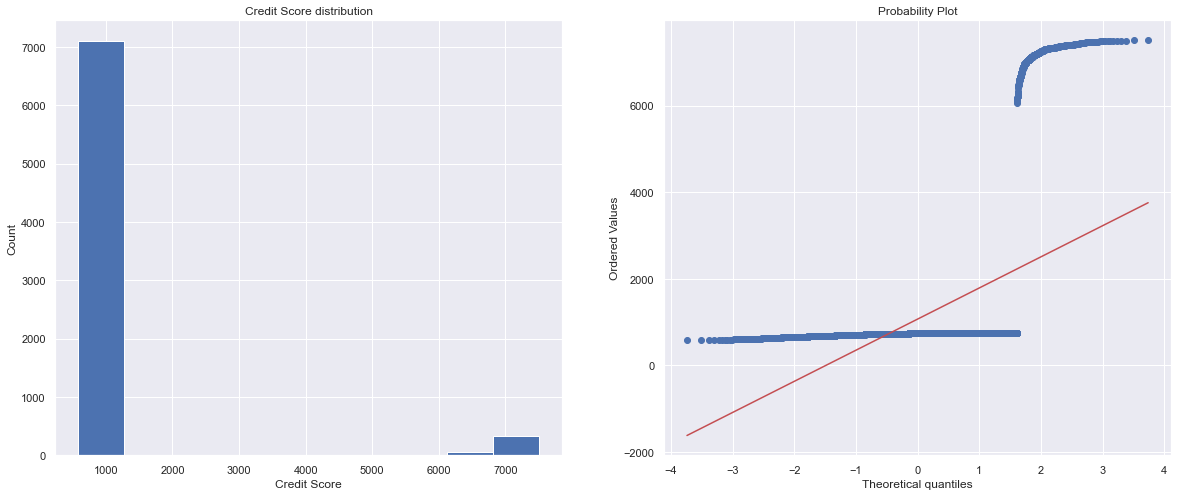

In [93]:
qq_plot('Credit Score')

In [94]:
df.loc[(df['Credit Score'] < 700), 'Credit Score'] = 0
df.loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 740), 'Credit Score'] = 1
df.loc[(df['Credit Score'] >= 740) & (df['Credit Score'] <= 750), 'Credit Score'] = 2
df.loc[(df['Credit Score'] >= 750) & (df['Credit Score'] <= 800), 'Credit Score'] = 3
df.loc[(df['Credit Score'] > 800), 'Credit Score'] = 4

df_test.loc[(df_test['Credit Score'] < 700), 'Credit Score'] = 0
df_test.loc[(df_test['Credit Score'] >= 700) & (df_test['Credit Score'] < 740), 'Credit Score'] = 1
df_test.loc[(df_test['Credit Score'] >= 740) & (df_test['Credit Score'] <= 750), 'Credit Score'] = 2
df_test.loc[(df_test['Credit Score'] >= 750) & (df_test['Credit Score'] <= 800), 'Credit Score'] = 3
df_test.loc[(df_test['Credit Score'] > 800), 'Credit Score'] = 4

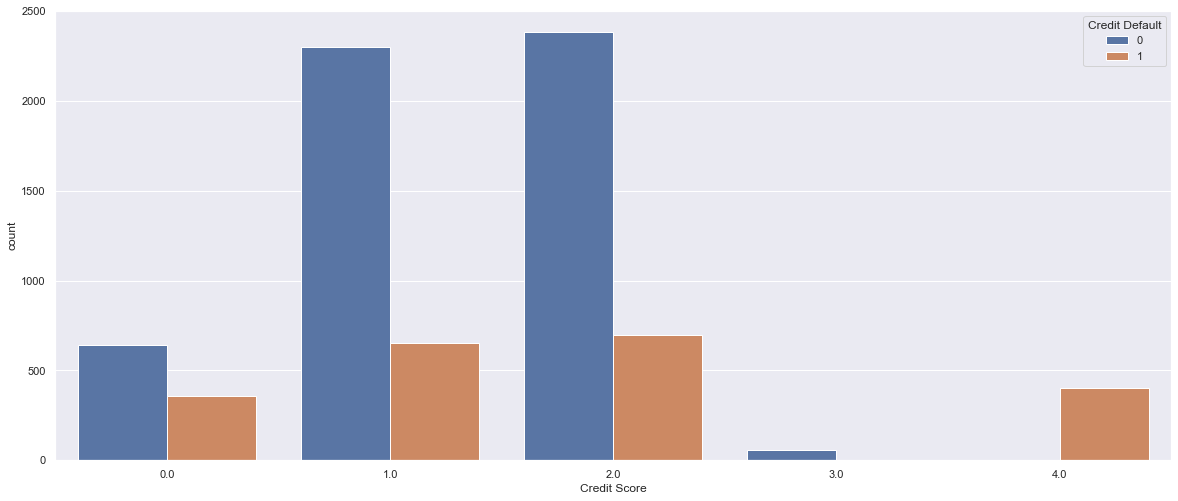

In [95]:
sns.countplot(x="Credit Score", hue='Credit Default', data=df)
plt.show()

In [96]:
#  ввод нового признака Good
df['Good'] = (df['Tax Liens'] == 0) & (df['Bankruptcies'] == 0) & (df['Number of Credit Problems'] == 0)
df_test['Good'] = (df_test['Number of Credit Problems'] == 0) \
                                & (df_test['Bankruptcies'] == 0) & (df_test['Tax Liens'] == 0)

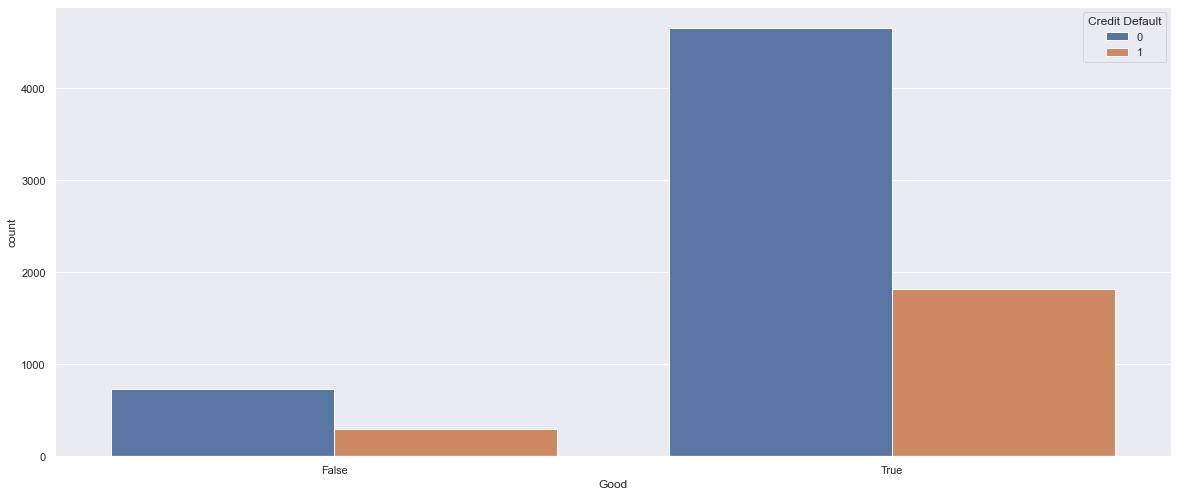

In [97]:
sns.countplot(x="Good", hue='Credit Default', data=df)
plt.show()

### Обзор целевой переменной

In [98]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [99]:
COL_SELECTED = [  
    
        'Current Loan Amount BIG',

        'Good',
        'Annual Income',
        'Years in current job',

        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
        'Purpose',
        'Term',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score',
    
        'Home Ownership_Have Mortgage',
        'Home Ownership_Home Mortgage',
        'Home Ownership_Own Home',
        'Home Ownership_Rent']

In [100]:
# выбираем числовые столбцы 
COL_SELECTED_NUM = [
        'Annual Income',
        'Years in current job',
        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score']

Annual Income
MannwhitneyuResult(statistic=9378180.5, pvalue=0.979695691934601)


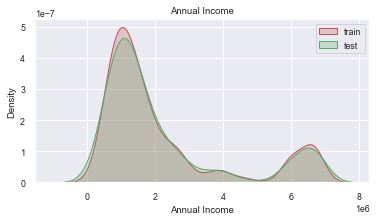

Years in current job
MannwhitneyuResult(statistic=9424506.5, pvalue=0.6869539783622054)


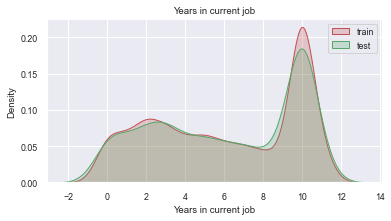

Number of Open Accounts
MannwhitneyuResult(statistic=9110102.5, pvalue=0.033160759360602116)


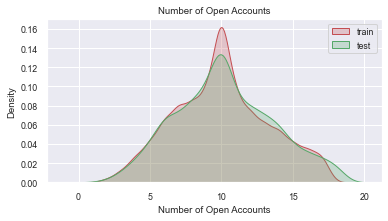

Years of Credit History
MannwhitneyuResult(statistic=9371339.0, pvalue=0.9766367483578579)


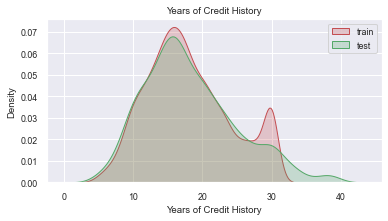

Maximum Open Credit
MannwhitneyuResult(statistic=9438926.5, pvalue=0.6090048663447776)


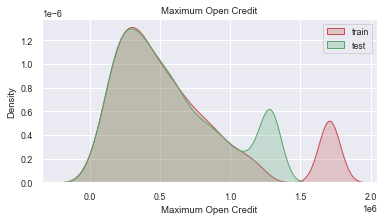

Current Loan Amount
MannwhitneyuResult(statistic=9074421.5, pvalue=0.016157982300107374)


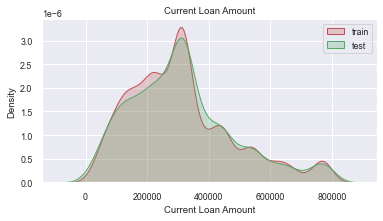

Current Credit Balance
MannwhitneyuResult(statistic=9516103.0, pvalue=0.2588933134132838)


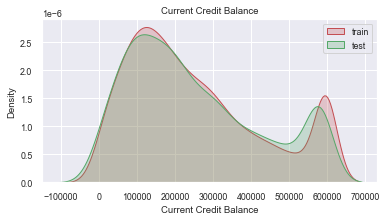

Monthly Debt
MannwhitneyuResult(statistic=9285486.0, pvalue=0.4739466712459831)


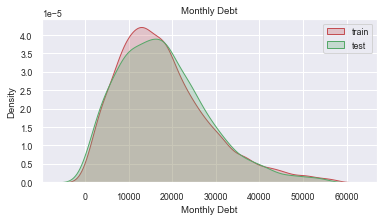

Credit Score
MannwhitneyuResult(statistic=9324673.0, pvalue=0.6657326041113452)


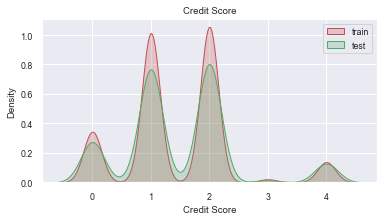

In [101]:
# смотрим, похожи ли распределения непрерывных показателей на train и test

from scipy.stats import mannwhitneyu

# p > 5% - распределения похожи
figsize = (6, 3)
for col in COL_SELECTED_NUM:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

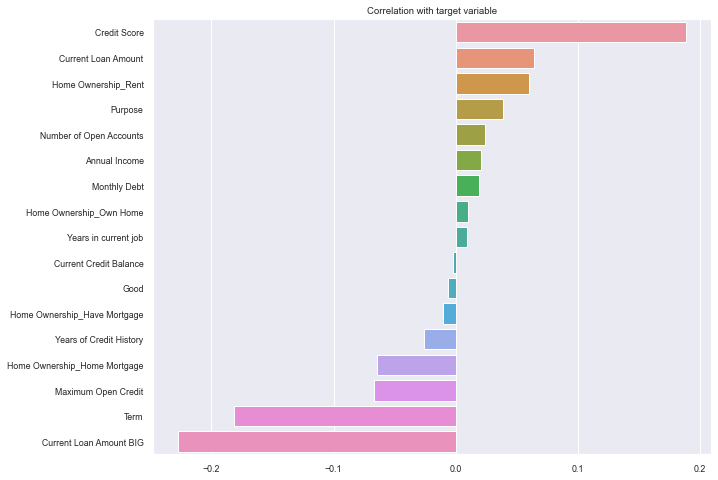

In [102]:
# влияние столбцов на целевой признак
corr_with_target = df[COL_SELECTED + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

In [103]:
# матрица корреляции
def cor_plot(data, method):
    plt.figure(figsize = (14,14))

    sns.set(font_scale=1)
    sns.heatmap(data.corr(method).round(2), annot=True, linewidths=.5, cmap='coolwarm')
    plt.title('Матрица корреляции');

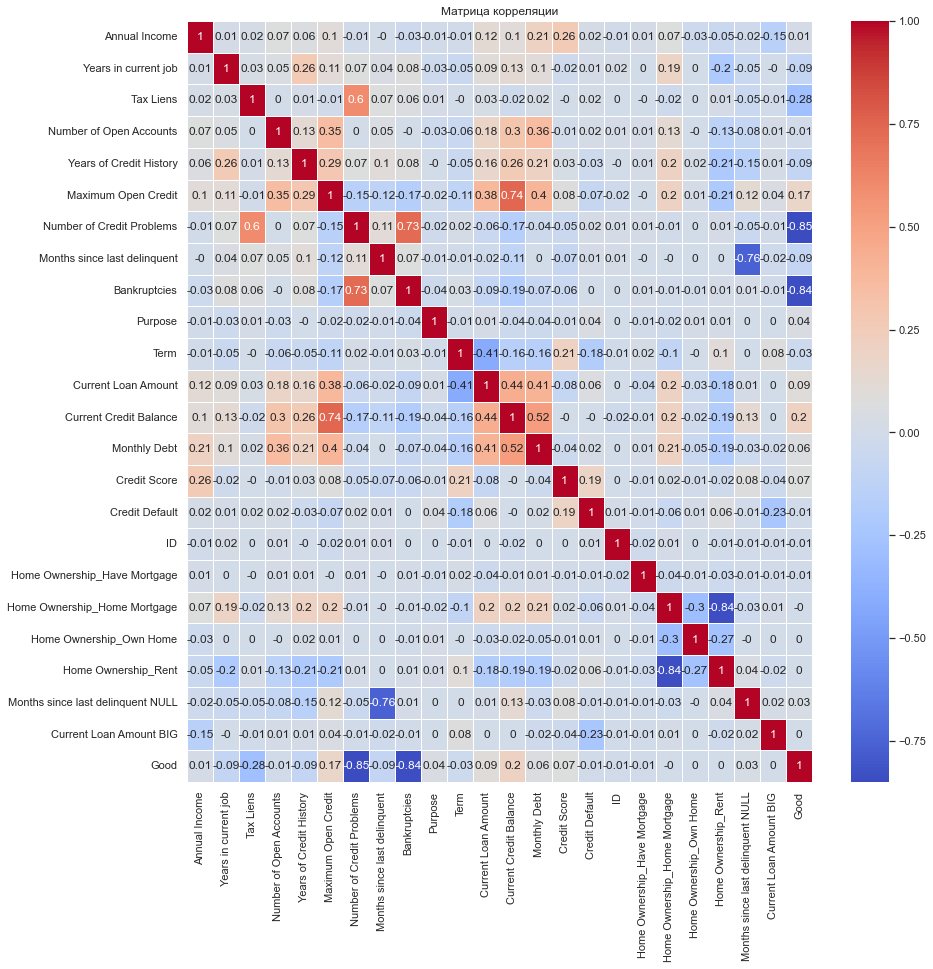

In [104]:
cor_plot(data=df, method='pearson');

### Балансировка классов

In [105]:
#  Разбиение на train и test
X = df[COL_SELECTED]
y = df['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,

                                                    test_size=0.30, 
                                                    random_state=21)

In [106]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [107]:
target_name='Credit Default'

In [108]:
balance_df_by_target(df, target_name)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,ID,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Months since last delinquent NULL,Current Loan Amount BIG,Good
2368,Own Home,6651900.0,3.0,0.0,9.0,23.0,701448.0,0.0,51.0,0.0,...,2.0,0,2368,0,0,1,0,False,False,True
8322,Home Mortgage,6651900.0,10.0,0.0,12.0,18.9,232782.0,1.0,0.0,1.0,...,2.0,1,347,0,1,0,0,True,False,False
4800,Home Mortgage,1128068.0,2.0,0.0,12.0,11.1,770814.0,0.0,0.0,0.0,...,2.0,0,4800,0,1,0,0,True,False,True
8875,Home Mortgage,1415747.0,10.0,0.0,11.0,25.0,283954.0,0.0,24.0,0.0,...,4.0,1,4588,0,1,0,0,False,False,True
9000,Rent,973560.0,11.0,0.0,3.0,30.0,0.0,0.0,0.0,0.0,...,2.0,1,2640,0,0,0,1,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8013,Rent,2615844.0,6.0,0.0,5.0,14.6,378928.0,0.0,0.0,0.0,...,2.0,1,3357,0,0,0,1,True,False,True
6273,Home Mortgage,670320.0,4.0,0.0,10.0,18.8,332112.0,1.0,0.0,1.0,...,1.0,0,6273,0,1,0,0,True,False,False
9145,Home Mortgage,699523.0,6.0,0.0,7.0,12.2,344146.0,0.0,0.0,0.0,...,4.0,1,4593,0,1,0,0,True,False,True
4220,Rent,1852690.0,10.0,0.0,7.0,16.1,267960.0,0.0,14.0,0.0,...,2.0,1,4220,0,0,0,1,False,False,True


In [109]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
df_balanced['Credit Default'].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [110]:
X_train = df_balanced.drop(columns='Credit Default')
y_train = df_balanced['Credit Default']

### Подбор моделей, получение бейзлана

In [111]:
def pred_model(model):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    print(model,'\n  --->  ', f1_score(y_test, y_test_pred))

In [112]:
for model in [
            LogisticRegression(C = 0.1, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 50),  
            #  Логистическая регрессия
    
            xgb.XGBClassifier(eval_metric="logloss", max_depth=50, reg_lambda=1, random_state=21), #  XGBoost
    
            KNeighborsClassifier(), # К-ближайших соседей
        
            RandomForestClassifier(), # Случайный лес    

            DecisionTreeClassifier(random_state=21, class_weight={0:1, 1:3.3}, max_depth=4), #  Дерево решений
    
            lgbm.LGBMClassifier(class_weight={0:1, 1:3.3}, random_state=21), #  Light GBM
    
            catb.CatBoostClassifier(class_weights=[1, 3.3], silent=True), #  CatBoost
    
            AdaBoostClassifier(),   #  AdaBoost
    
            SVC(C=0.05, kernel='rbf'), # Метод опорных векторов
    
            GaussianNB(),  #  Гауссовский наивный байесовский
    
            ExtraTreesClassifier(random_state=42, bootstrap=True, min_samples_split=0.3, class_weight='balanced'),
            #  Чрезвычайно рандомизированные деревья
    
            GradientBoostingClassifier(learning_rate=7, random_state=42), # Бустинг
    
            Perceptron(class_weight='balanced')  # Алгоритм Perceptron
]:
        pred_model(model)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=50, penalty='l1',
                   solver='liblinear') 
  --->   0.4945454545454545
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=50,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=21, ...) 
  --->   0.4487534626038781
KNeighborsClassifier() 
  --->   0.35855988243938286
RandomForestClassif

### Выбор наилучшей модели, настройка гиперпараметров

In [113]:
#  Отчёт по оценке модели
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [114]:
# Логистическая регрессия
lr = LogisticRegression(penalty='l2',
                       tol=1e-8, #критерий останова
                        C=1e-2, #регуляризация
                       class_weight='balanced', 
                       random_state=43,
                       max_iter=400, #количество итераций
                       n_jobs=-1)

In [115]:
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.39      0.48      3771
           1       0.48      0.71      0.57      2958

    accuracy                           0.53      6729
   macro avg       0.56      0.55      0.53      6729
weighted avg       0.57      0.53      0.52      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.40      0.52      1616
           1       0.31      0.70      0.43       634

    accuracy                           0.48      2250
   macro avg       0.54      0.55      0.48      2250
weighted avg       0.64      0.48      0.50      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               639  977
1               190  444


In [116]:
#  XGBoost
model_xgb =xgb.XGBClassifier (eval_metric="logloss", use_label_encoder=False, random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3771
           1       0.98      0.96      0.97      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.97      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1616
           1       0.51      0.44      0.47       634

    accuracy                           0.72      2250
   macro avg       0.65      0.64      0.64      2250
weighted avg       0.71      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1349  267
1                356  278


In [117]:
#  модель ближайших соседей

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      3771
           1       0.73      0.66      0.69      2958

    accuracy                           0.74      6729
   macro avg       0.74      0.73      0.74      6729
weighted avg       0.74      0.74      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1616
           1       0.34      0.38      0.36       634

    accuracy                           0.61      2250
   macro avg       0.54      0.54      0.54      2250
weighted avg       0.63      0.61      0.62      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1133  483
1                390  244


In [118]:
#  модель CatBoost  

model_catb = catb.CatBoostClassifier(silent=True, random_state=11)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3771
           1       0.94      0.85      0.89      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.90      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1616
           1       0.56      0.46      0.51       634

    accuracy                           0.75      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1383  233
1                340  294


### Проверка качества, борьба с переобучением, интерпритация результатов.

In [119]:
# отдельно модель CatBoost

model_catb = catb.CatBoostClassifier(class_weights=[1, 3.3],
                                    depth=3,
                                    iterations=400, 

                                    silent=True, 

                                    )



model_catb.fit(X_train, y_train)


y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

print('CatBoost: ')
print(f'f-score {f1_score(y_test, y_test_pred)}')

CatBoost: 
f-score 0.49917627677100496


###  Сохранение результатов.

In [120]:
df_test["Credit Default"] = model_catb.predict(df_test[COL_SELECTED])


df_test['ID'] = df_test.index.tolist()
df_test['ID'] = df_test['ID']
df_test1 = df_test[['Credit Default', 'ID']]

df_test1.to_csv(r'APokusay_predictions.csv', index=False)

### 